In [1]:
import os
import sys
sys.path.append("../behavioral_cloning")
sys.path.append("../")
from build_seq_dataset import *
import load_policy
import gym
import seaborn as sbn
import numpy as np

In [2]:
N_WINDOW = 5

### Load & prep humanoid dataset

In [3]:
train_observations, train_actions = load_expert_data("../expert_data/train/Humanoid-v2.pkl")
test_observations, test_actions = load_expert_data("../expert_data/test/Humanoid-v2.pkl")

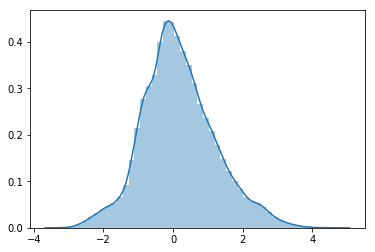

In [4]:
sbn.distplot(train_actions.ravel())

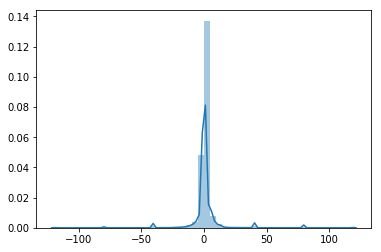

In [5]:
sbn.distplot(train_observations.ravel())

In [4]:
train_dataset = build_in_mem_tf_dataset(train_observations, train_actions)
train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=True).batch(64)
# test_dataset = build_in_mem_tf_dataset(test_observations, test_actions).batch(64)

In [5]:
train_dataset

<BatchDataset shapes: ((None, 5, 376), (None, 34)), types: (tf.float64, tf.float64)>

### Define model

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, activation="relu", return_sequences=True), # state embedding
    tf.keras.layers.LSTM(128, activation="relu", return_sequences=True),
    tf.keras.layers.LSTM(64, activation="relu"),
    tf.keras.layers.Dense(34, activation="tanh")
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])

In [6]:
model.fit(train_dataset, epochs=10)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

298/298 [==============================] - 6s 22ms/step - mean_squared_error: 0.1060 - loss: 0.1060
Epoch 2/10
298/298 [==============================] - 6s 21ms/step - mean_squared_error: 0.0504 - loss: 0.0504
Epoch 3/10
298/298 [==============================] - 6s 20ms/step - mean_squared_error: 0.0394 - loss: 0.0394
Epoch 4/10
298/298 [==============================] - 6s 21ms/step - mean_squared_error: 0.0332 - loss: 0.0332
Epoch 5/10
298/298 [==============================] - 6s 21ms/st

In [7]:
model.evaluate(test_dataset)

79/79 [==============================] - 1s 9ms/step - mean_squared_error: 0.0268 - loss: 0.0268


[0.026836954057216644, 0.026836954057216644]

### Test in Gym env

In [8]:
def decode_cos_sin(a):
    return np.arctan(np.divide(a[:, -17:], a[:, :17]))

In [6]:
env = gym.make("Humanoid-v2")
max_steps = env.spec.timestep_limit
print(max_steps)

expert_policy_fn = load_policy.load_policy("../experts/Humanoid-v2.pkl")

returns = []
observations = []
actions = []
expert_actions = []
for i in range(50):
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    
    rolling_input = []
    while not done:
        if len(rolling_input) >= N_WINDOW:
            rolling_input = np.append(rolling_input[1:], obs[None, :], 0)
        else:
            rolling_input.append(obs[:])
            rolling_input = np.append(np.zeros(((N_WINDOW - len(rolling_input)), 376)), np.array(rolling_input), 0)

        action = decode_cos_sin(model.predict(np.array([rolling_input])))
        
#         observations.append(np.array(rolling_input))
        observations.append(obs[:])
        actions.append(action)
        expert_actions.append(expert_policy_fn(obs[None, :]).numpy())
        obs, r, done, _ = env.step(action)
#         print("r:", r)
        totalr += r
        steps += 1
        if True:
            env.render()
        if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            break
    print("total:", totalr, steps)
    print("Average reward: %.2f" % (float(totalr)/steps))
#     returns.append(totalr)

/Users/shawnlin/.pyenv/versions/3.5.10/envs/3.5-RL/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1000
iter 0


NameError: name 'decode_cos_sin' is not defined

### Dagger Improvement - Generate new dataset

In [25]:
np.array(observations).shape

(933, 376)

In [35]:
np.array(expert_actions).shape

(1198, 1, 17)

In [26]:
dagger_data = {'observations': np.array(observations),
               'actions': np.array(expert_actions)}

with open(os.path.join('../dagger_data/train', "Humanoid-v2-rnn-step0.pkl"), 'wb') as f:
    pickle.dump(dagger_data, f, pickle.HIGHEST_PROTOCOL)

In [27]:
# Sample from both dagger_data and expert_data
train_dagger_observations, train_dagger_actions = load_expert_data("../dagger_data/train/Humanoid-v2-rnn-step0.pkl")
train_dagger_observations.shape
train_dagger_dataset = build_in_mem_tf_dataset(train_dagger_observations, train_dagger_actions)
train_dagger_dataset = train_dagger_dataset.shuffle(len(train_dagger_dataset), reshuffle_each_iteration=True).batch(64)


In [28]:
len(train_dagger_dataset)

15

In [31]:
len(train_dataset)

336

In [7]:
# new_train_dataset = tf.data.experimental.sample_from_datasets(
#     [train_dataset, train_dagger_dataset], [0.8, 0.2])#.batch(64)
train_dataset = train_dataset.concatenate(train_dagger_dataset)

NameError: name 'train_dagger_dataset' is not defined

In [101]:
for o, a in train_dataset:
    print(o.shape, a.shape)
    break

(64, 5, 376) (64, 34)


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, activation="relu", return_sequences=True), # state embedding
    tf.keras.layers.LSTM(128, activation="relu", return_sequences=True),
    tf.keras.layers.LSTM(64, activation="relu"),
    tf.keras.layers.Dense(34, activation="tanh")
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])

model.fit(train_dataset, epochs=10)
model.evaluate(test_dataset)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

336/336 [==============================] - 7s 20ms/step - mean_squared_error: 0.1320 - loss: 0.1320
Epoch 2/10
336/336 [==============================] - 7s 20ms/step - mean_squared_error: 0.0842 - loss: 0.0842
Epoch 3/10
336/336 [==============================] - 7s 20ms/step - mean_squared_error: 0.0675 - loss: 0.0675
Epoch 4/10
336/336 [==============================] - 7s 22ms/step - mean_squared_error: 0.0564 - loss: 0.0564
Epoch 5/10
336/336 [==============================] - 7s 21ms/st

[0.05700341984629631, 0.05700341984629631]